In [1]:
import matplotlib
import os
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, AutoModelForSeq2SeqLM
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax
from datasets import Dataset
import torch
from nltk.tokenize import word_tokenize
import nltk
from scipy.spatial import distance
from scipy.special import softmax

In [2]:
emo_model_id = "SamLowe/roberta-base-go_emotions"
tokenizer = AutoTokenizer.from_pretrained(emo_model_id)
model = AutoModelForSequenceClassification.from_pretrained("SamLowe/roberta-base-go_emotions")
emo_classifier = pipeline('text-classification', model=emo_model_id,tokenizer=emo_model_id, max_length=512, truncation=True, top_k=None)

In [4]:
if(os.path.exists('../modeldata/empathetic_dialogues_original_dataset.p')):
    print("LOADING data")
    with open('../modeldata/empathetic_dialogues_original_dataset.p', "rb") as f:
        [dataset] = pickle.load(f)
    f.close()

LOADING data


In [5]:
tokenizer.model_max_length

512

In [47]:
eg = emo_classifier(dataset["train"]["utterance"][0])
eg_score = [s.get('score') for s in eg[0]]
sum(eg_score)

1.1706438591936603

In [10]:
sample = emo_classifier(dataset["train"]["utterance"][0:10])

In [52]:
def old_get_emo_probi(sample):
    labels = [s.get('label') for s in sample[0]]
    score = [[s.get('score') for s in sam] for sam in sample]
    score_arr = np.array(score)
    score_arr = score_arr.T
    sum_scores = np.array([sum(s) for s in score_arr])
    probi = softmax(sum_scores)
    label_scores = []
    for i in range(len(labels)):
        x = (labels[i], probi[i])
        label_scores.append(x)
    return label_scores.sort(key=lambda tup: tup[1], reverse=True)

In [78]:
labels = [s.get('label') for s in sample[0]]
zeros = [0] * len(labels)
score_dict = dict(zip(labels,zeros))
label_scores = []
for sam in sample:
    for s in sam:
        emo = s.get('label')
        prev_score = score_dict[emo]
        score = s.get('score')
        score_dict[emo] = (prev_score + score)
# change to probi
all_scores = list(zip(*score_dict.items()))[1]
probi = softmax(all_scores)
score_dict = dict(zip(labels,probi))
score_dict = sorted(score_dict.items(), key=lambda x:x[1], reverse=True)

[('neutral', 0.2530616956832425),
 ('curiosity', 0.12921492280263788),
 ('confusion', 0.0738306315148129),
 ('sadness', 0.0482371437428264),
 ('surprise', 0.03587667325852218),
 ('approval', 0.027411716118277803),
 ('joy', 0.026921112558743538),
 ('realization', 0.025531640326931986),
 ('disappointment', 0.025022003909501413),
 ('excitement', 0.02349562258368893),
 ('love', 0.022145996501914716),
 ('annoyance', 0.021535681478386786),
 ('admiration', 0.021207862211739363),
 ('disapproval', 0.019597374676149693),
 ('fear', 0.01853512205533829),
 ('grief', 0.01832187517925066),
 ('optimism', 0.01831769369928469),
 ('relief', 0.018037472424980678),
 ('caring', 0.01758651006451214),
 ('anger', 0.017559925172073856),
 ('embarrassment', 0.017531235423875427),
 ('disgust', 0.017500687213616),
 ('nervousness', 0.01745685934177435),
 ('amusement', 0.01740437575051111),
 ('remorse', 0.017282599314999036),
 ('desire', 0.017197942152859285),
 ('pride', 0.017135835933588396),
 ('gratitude', 0.017041

In [ ]:
score = [[s.get('score') for s in sam] for sam in sample] # the returned result is sorted, rewrite
score_arr = np.array(score)
score_arr = score_arr.T
sum_scores = np.array([sum(s) for s in score_arr])
probi = softmax(sum_scores)
label_scores = []
for i in range(len(labels)):
    x = (labels[i], probi[i])
    label_scores.append(x)
label_scores.sort(key=lambda tup: tup[1], reverse=True)

[('joy', 5.63504846394062),
 ('excitement', 2.4575039595365524),
 ('realization', 1.4925023838877678),
 ('neutral', 0.6332378573715687),
 ('love', 0.4150326941162348)]

In [41]:
max5 = label_scores[:5]
best_labels = list(zip(*max5))[0]
best_scores = list(zip(*max5))[1]

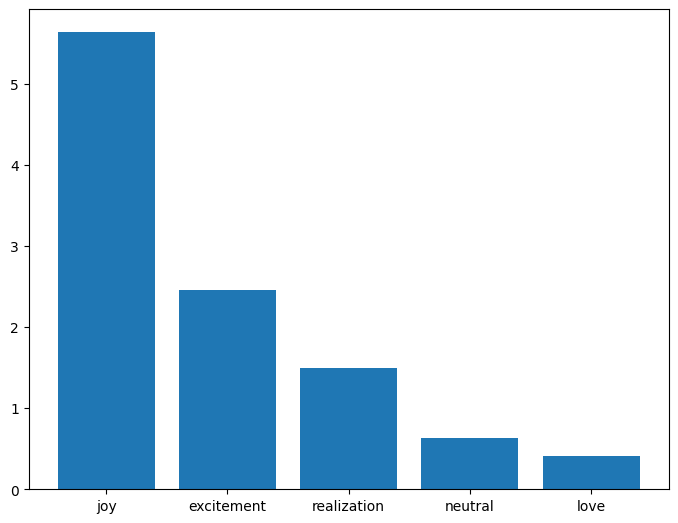

In [42]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(best_labels,best_scores)
plt.show()

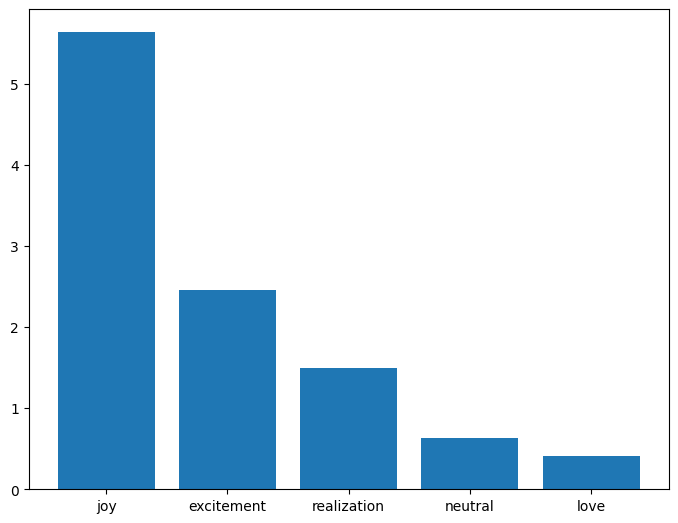

In [33]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels[:5],sum_scores[:5])
plt.show()

In [43]:
sum(sum_scores)

12.030187703014235

In [50]:
probi = softmax(sum_scores)
print(probi)

[0.86415393 0.03602476 0.01372481 0.00581209 0.00467269 0.0041076
 0.0038463  0.00364373 0.00347993 0.00341201 0.00332971 0.00326931
 0.0032304  0.00321722 0.00321038 0.00319599 0.00317983 0.00317093
 0.00316187 0.00315652 0.00314779 0.00313843 0.00313498 0.00312869
 0.00312284 0.0031163  0.00310997 0.00310098]


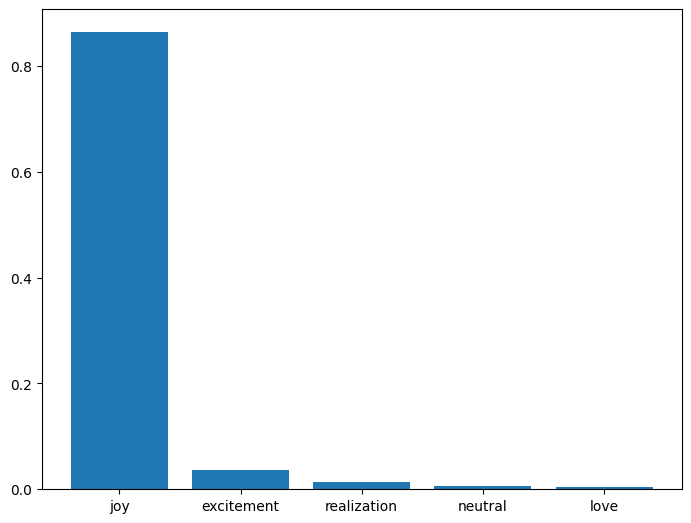

In [51]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels[:5],probi[:5])
plt.show()

In [114]:
with open("../modeldata/emo_classified_dataset.p", "rb") as f:
    [train_results, dev_results, test_results] = pickle.load(f)
f.close()

In [115]:
# TODO create a dict, add score to dict directly
def get_emo_scores(sample):
    labels = [s.get('label') for s in sample[0]]
    zeros = [0] * len(labels)
    score_dict = dict(zip(labels,zeros))
    label_scores = []
    for sam in sample:
        for s in sam:
            emo = s.get('label')
            prev_score = score_dict[emo]
            score = s.get('score')
            score_dict[emo] = (prev_score + score)
    # change to probi
    all_scores = list(zip(*score_dict.items()))[1]
    #probi = softmax(all_scores)
    score_dict = dict(zip(labels,probi))
    score_dict = sorted(score_dict.items(), key=lambda x:x[1], reverse=True)
    return score_dict

In [116]:
print(train_results[:2])

[[{'label': 'joy', 'score': 0.42014196515083313}, {'label': 'excitement', 'score': 0.17859642207622528}, {'label': 'realization', 'score': 0.14372269809246063}, {'label': 'neutral', 'score': 0.09388687461614609}, {'label': 'love', 'score': 0.06275704503059387}, {'label': 'surprise', 'score': 0.05986616387963295}, {'label': 'approval', 'score': 0.05472484230995178}, {'label': 'admiration', 'score': 0.03221727907657623}, {'label': 'relief', 'score': 0.021137148141860962}, {'label': 'pride', 'score': 0.017641644924879074}, {'label': 'sadness', 'score': 0.01302679069340229}, {'label': 'amusement', 'score': 0.009152797982096672}, {'label': 'nervousness', 'score': 0.0070704803802073}, {'label': 'desire', 'score': 0.006731221452355385}, {'label': 'disappointment', 'score': 0.006665147840976715}, {'label': 'fear', 'score': 0.006006049457937479}, {'label': 'gratitude', 'score': 0.005065568257123232}, {'label': 'grief', 'score': 0.00476900115609169}, {'label': 'optimism', 'score': 0.004678830504

In [203]:
train_emo_scores = dict(get_emo_scores(train_results))
dev_emo_scores = dict(get_emo_scores(dev_results))
test_emo_scores = dict(get_emo_scores(test_results))

In [204]:
def append_scores(original, sample):
    labels = list(original.keys())
    all_emo_scores = original
    for l in labels:
        emo_score = sample.get(l)
        prev_score = original[l]
        all_emo_scores[l] = (prev_score + emo_score)
    return all_emo_scores

In [205]:
#all_emo_scores = {}
all_emo_scores = append_scores(train_emo_scores, dev_emo_scores)
all_emo_scores = append_scores(all_emo_scores, test_emo_scores)
all_emo_scores

{'neutral': 0.30005294085062034,
 'curiosity': 0.2759610810291512,
 'confusion': 0.10855980909154761,
 'sadness': 0.0959147805716731,
 'surprise': 0.07131852143401397,
 'approval': 0.09916506263532215,
 'joy': 0.07153077082988063,
 'realization': 0.531655031693417,
 'disappointment': 0.07745572393728063,
 'excitement': 0.05985497018792027,
 'love': 0.0632790526564512,
 'annoyance': 0.06401454472966256,
 'admiration': 0.09065286816630513,
 'disapproval': 0.056667618786826274,
 'fear': 0.07237734717282536,
 'grief': 0.08615639359822674,
 'optimism': 0.05276385835575574,
 'relief': 0.052579948544556616,
 'caring': 0.05336524458553715,
 'anger': 0.05346412893587068,
 'embarrassment': 0.053435439187672254,
 'disgust': 0.05584438535894376,
 'nervousness': 0.06513449617062106,
 'amusement': 0.05607589316248629,
 'remorse': 0.16405744728971078,
 'desire': 0.1648592051824851,
 'pride': 0.05219644831927825,
 'gratitude': 0.051606987535958014}

In [206]:
all_emo_scores = dict(sorted(all_emo_scores.items(), key=lambda x:x[0].lower()))

In [187]:
sum(all_emo_scores.values())

3.0000000000000004

In [207]:
all_scores = list(all_emo_scores.values())
all_probi = softmax(all_scores)
# sort
all_emo_probi = dict(zip(list(all_emo_scores.keys()), all_probi))
all_emo_probi = sorted(all_emo_probi.items(), key=lambda x:x[0].lower())
all_emo_probi
#all_scores = sorted(all_scores.items(), key=lambda x:x[1], reverse=True)

[('admiration', 0.03492661190430042),
 ('amusement', 0.033739595300064304),
 ('anger', 0.03365159040608178),
 ('annoyance', 0.03400850818171535),
 ('approval', 0.035225182961619),
 ('caring', 0.03364826295494592),
 ('confusion', 0.03555767401348014),
 ('curiosity', 0.04203729793391528),
 ('desire', 0.037616974365008576),
 ('disappointment', 0.03446870852390645),
 ('disapproval', 0.03375956579110115),
 ('disgust', 0.03373178522454558),
 ('embarrassment', 0.03365062496427576),
 ('excitement', 0.03386734105800712),
 ('fear', 0.03429410715644761),
 ('gratitude', 0.03358915264019124),
 ('grief', 0.03476991783158706),
 ('joy', 0.034265086862307004),
 ('love', 0.033983504389698514),
 ('nervousness', 0.034046617395709536),
 ('neutral', 0.04306235278235209),
 ('optimism', 0.033628033436435376),
 ('pride', 0.03360895796507528),
 ('realization', 0.05428517779614199),
 ('relief', 0.03362184947981766),
 ('remorse', 0.03758682674606981),
 ('sadness', 0.03511087704511565),
 ('surprise', 0.03425781489

In [208]:
f = open("../modeldata/emo_probi.p", 'wb')
pickle.dump([all_emo_probi, all_emo_scores], f) # sort by key alphabetically
f.close()

In [199]:
max5 = all_emo_probi[:10]
best_labels = list(zip(*max5))[0]
best_scores = list(zip(*max5))[1]
#best_scores = max5
print(best_scores)
best_labels


(0.054285177796142, 0.0430623527823521, 0.04203729793391529, 0.03761697436500858, 0.037586826746069814, 0.035557674013480145, 0.03522518296161901, 0.03511087704511566, 0.03492661190430043, 0.03476991783158707)


('realization',
 'neutral',
 'curiosity',
 'desire',
 'remorse',
 'confusion',
 'approval',
 'sadness',
 'admiration',
 'grief')

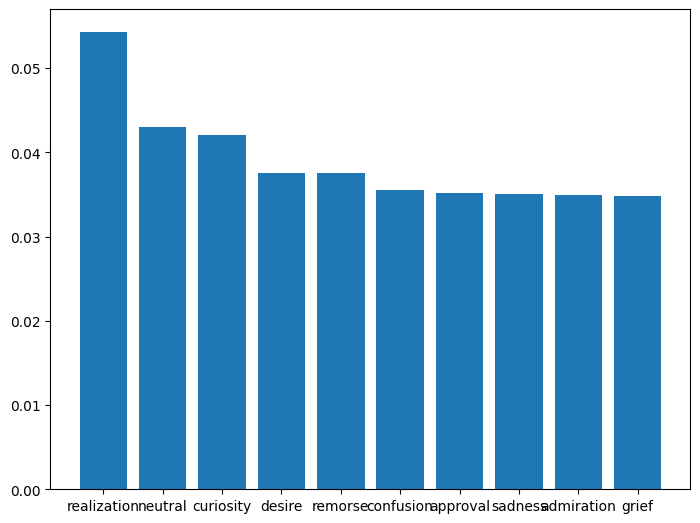

In [200]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(best_labels,best_scores)
plt.show()

# Run Test Set

In [3]:
if(os.path.exists('modeldata/emo_probi.p')):
    print("LOADING data emotion probability distribution...")
    with open('modeldata/emo_probi.p', "rb") as f:
        [all_emo_probi, _] = pickle.load(f)
    f.close()
all_emo_probi = dict(all_emo_probi)

NameError: name 'all_emo_probi' is not defined

In [4]:
def weighted_bleu_score(target, response):
    score1 = nltk.translate.bleu_score.sentence_bleu([target], response, weights=(1, 0, 0))
    score2 = nltk.translate.bleu_score.sentence_bleu([target], response, weights=(0, 1, 0))
    score3 = nltk.translate.bleu_score.sentence_bleu([target], response, weights=(0, 0, 1))
    ngram_score_list = [score1, score2, score3]
    return (sum(ngram_score_list) / len(ngram_score_list))

In [5]:
print("Start testing.")
device = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"
BLEU_score_list = []
texts = []
ppo_model = "../DEV-blenderbot-400m-emo-probi-bleu-last-bleu0.0589"
model_id = ppo_model
model = AutoModelForSeq2SeqLM.from_pretrained(model_id, device_map={"": device}, torch_dtype=torch.float32)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

Start testing.


OSError: Can't load the configuration of '../DEV-blenderbot-400m-emo-probi-bleu-last-bleu0.0589'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure '../DEV-blenderbot-400m-emo-probi-bleu-last-bleu0.0589' is the correct path to a directory containing a config.json file

In [6]:
with open("../modeldata/test_dialogue_dataset.p", "rb") as f:
    [test_dataset] = pickle.load(f)
test_dataset = Dataset.from_dict(test_dataset)

def tokenize(sample):
    prompt = sample["prompt"] # prompt
    continuation = sample["target"] # utterance

    sample["input_ids"] = tokenizer.encode(prompt)
    #sample["target_ids"] = tokenizer.encode(continuation)[: input_size()]
    sample["query"] = {"prompt": tokenizer.decode(sample["input_ids"]), "target": continuation}
    return sample

test_dataset = test_dataset.map(tokenize, batched=False)
test_dataset.set_format(type="torch")
emp_weight = 0.2
fluency_weight = 0.8

Map:   0%|          | 0/8401 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1844 > 512). Running this sequence through the model will result in indexing errors


In [8]:
print("Start testing.")
#try:
prompts = []
for test_query in test_dataset:
    input_texts = test_query["prompt"]
    input_ids = tokenizer(input_texts, return_tensors="pt", padding=True).to(device)
    outputs = model.generate(input_ids, do_sample=True, max_new_tokens=40, use_cache=True)
    generated_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    texts.append(generated_texts[0])
    print(generated_texts)

    # Calculate bleu score
    dev_prompt = test_query["prompt"]
    prompts.append(dev_prompt)
    test_response = word_tokenize(generated_texts[0])
    dev_target = word_tokenize(test_query["target"])
    dev_BLEUscore = weighted_bleu_score(dev_target, test_response)
    BLEU_score_list.append(dev_BLEUscore)

mean_bleu = sum(BLEU_score_list) / len(BLEU_score_list)

# calculate emo distribution
prompt_results = emo_classifier(prompts)
emo_results = emo_classifier(texts)
labels = [s.get('label') for s in emo_results[0]]
zeros = [0] * len(labels)
score_dict = dict(zip(labels, zeros))

for i in range(len(prompt_results)):
    prompt_value = sorted(prompt_results[i].items(), key=lambda x: x[0].lower())
    #prompt_value = list(prompt_value)
    print(prompt_value)
    response_value = sorted(emo_results[i].items(), key=lambda x: x[0].lower())
    print(response_value)
    #response_value = list(emo_results[i].values())


"""
empathy_results = append_scores(score_dict, emo_results)
# sort alphabetically
empathy_results = dict(sorted(empathy_results.items(), key=lambda x: x[0].lower()))
all_emo_probi_values = list(all_emo_probi.values())
empathy_results_values = list(empathy_results.values())

js_distance = distance.jensenshannon(all_emo_probi_values, empathy_results_values)

# js_distance: identical = 0, entirely different = 1, reverse this for reward
emo_score = js_distance

current_score = (emo_score * emp_weight) + ((1-mean_bleu) * fluency_weight)
with open(f'DEV_test_score_log_emo_probi_score.txt', 'wb') as score_log:
    score_log.write(f"Mean BLEU of this model: {mean_bleu}. \n")
    score_log.write(f"Score of this model: {current_score}. \n")
    print(f"Mean BLEU of this model: {mean_bleu}. \n")
    print(f"Score of this model: {current_score}. \n")
score_log.close()
"""
#except Exception as err:
#    with open(f'DEV_test_error_log_emo_probi_score.txt', 'w') as err_log:
#        err_log.write(f"Unexpected {err=}, {type(err)=}")
#    err_log.close()

Start testing.


TypeError: The current model class (RobertaForSequenceClassification) is not compatible with `.generate()`, as it doesn't have a language model head. Please use one of the following classes instead: {'RobertaForCausalLM'}